#### Labels transfer from fetal stem cells single-cell RNA sequencing cells to stem cells found in Xenium add-on data
- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 21st March 2024
- **Last modified date:** 18th October 2024

##### Import packages

In [56]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt

##### Setup working environment

In [57]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
array_api_compat            1.4
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy

In [58]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [59]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [60]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [61]:
adata_xenium = sc.read_h5ad('data/10X_Xenium_adult_colon_data/Annotation_prediction/Xenium_cell_states_161024.h5ad')

In [62]:
X_is_raw(adata_xenium)

True

In [63]:
adata_fetal_sc = sc.read_h5ad('data/Fetal_stem_cells_leiden.h5ad')

In [64]:
X_is_raw(adata_fetal_sc)

True

+ Check common genes between 2 datasets

In [65]:
common_genes = adata_xenium.var_names.intersection(adata_fetal_sc.var_names)
print(len(common_genes))

377


+ Save raw counts

In [66]:
adata_fetal_sc.raw = adata_fetal_sc

In [67]:
adata_xenium.raw = adata_xenium

+ Prepare obs

In [68]:
adata_xenium = adata_xenium[adata_xenium.obs['C_scANVI'] == 'Stem cells']

In [69]:
adata_fetal_sc.obs['seed_labels'] = adata_fetal_sc.obs['cluster'].copy()

In [70]:
adata_xenium.obs['seed_labels'] = 'Unknown'

In [71]:
adata_xenium.obs['Study_name'] = '10X_Xenium_gut_data'

+ Concatenate datasets

In [72]:
adata = adata_fetal_sc.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)

+ Run scVI

In [73]:
adata.layers['counts'] = adata.X.copy()

In [74]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')

In [75]:
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown               14880
MTRNR2L12+ASS1+_SC     3979
RPS10+_RPS17+_SC       3544
FXYD3+_CKB+_SC          294
Name: count, dtype: int64

In [76]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Donor_ID', 
                                                          'Library_Preparation_Protocol', 
                                                          'Study_name'],
                              labels_key = "seed_labels", 
                              layer = 'counts')

In [77]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [78]:
scvi_model.train(500, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 500/500: 100%|█| 500/500 [08:08<00:00,  1.03it/s, v_num=1, train_loss_step=133, tra

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|█| 500/500 [08:08<00:00,  1.02it/s, v_num=1, train_loss_step=133, tra


In [79]:
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

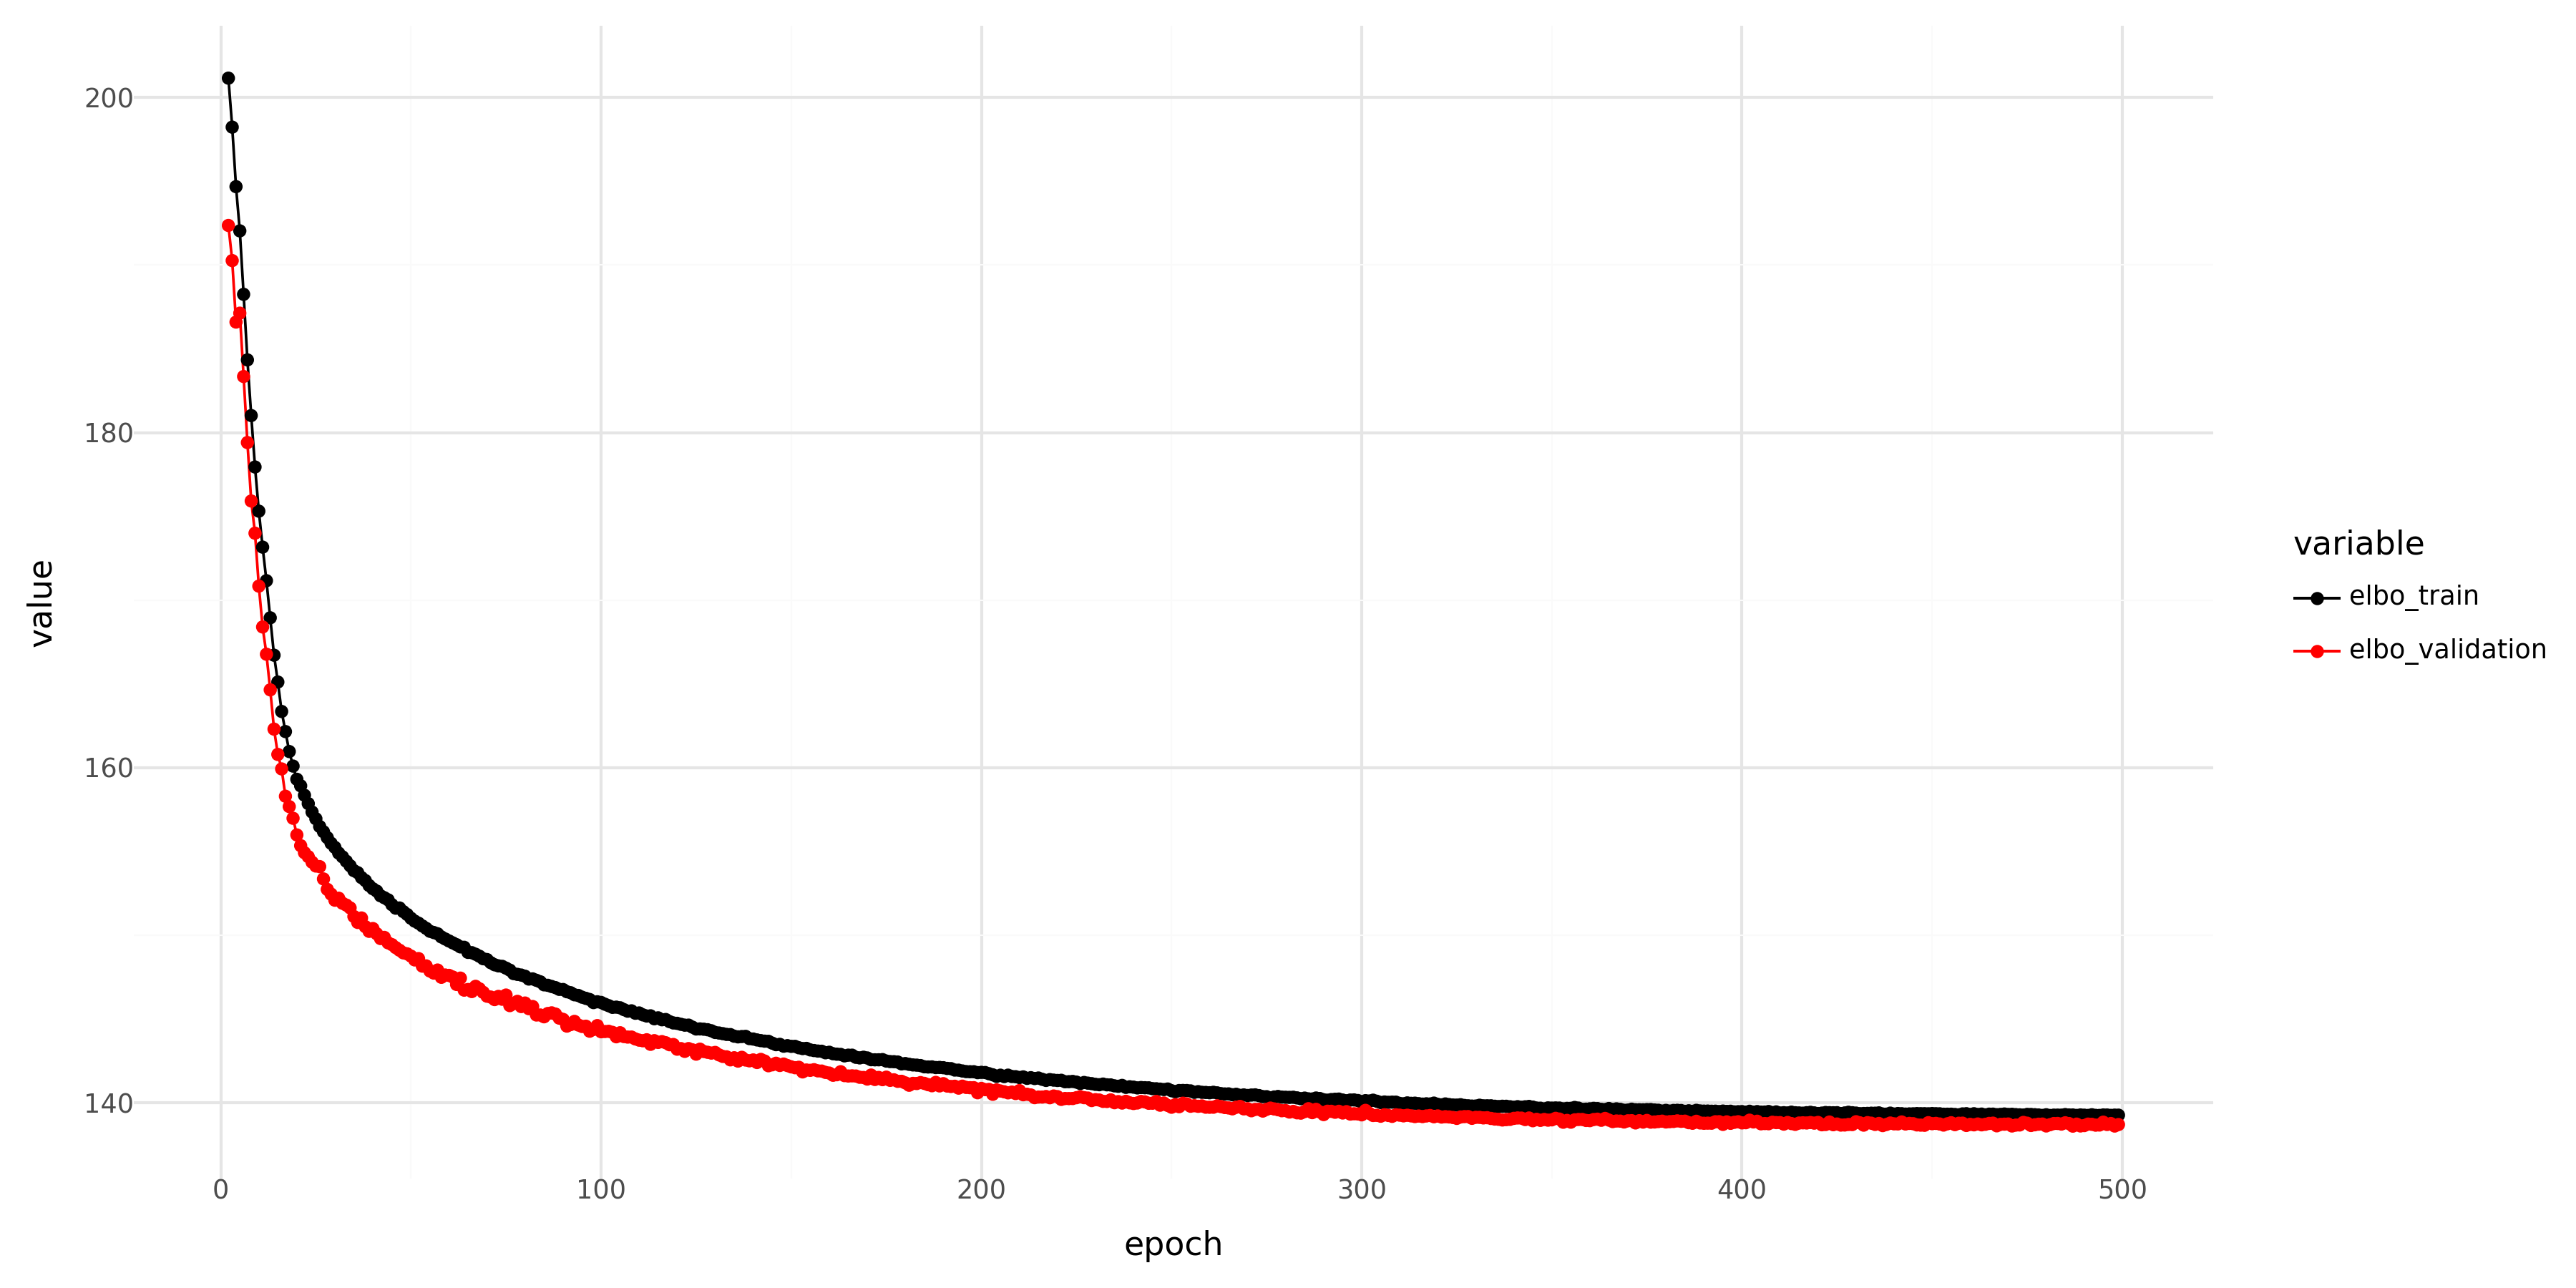

In [83]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 1'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [90]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [91]:
scanvi_model.train(400, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 400 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|█| 400/400 [17:51<00:00,  2.61s/it, v_num=1, train_loss_step=127, tra

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [17:51<00:00,  2.68s/it, v_num=1, train_loss_step=127, tra


In [92]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

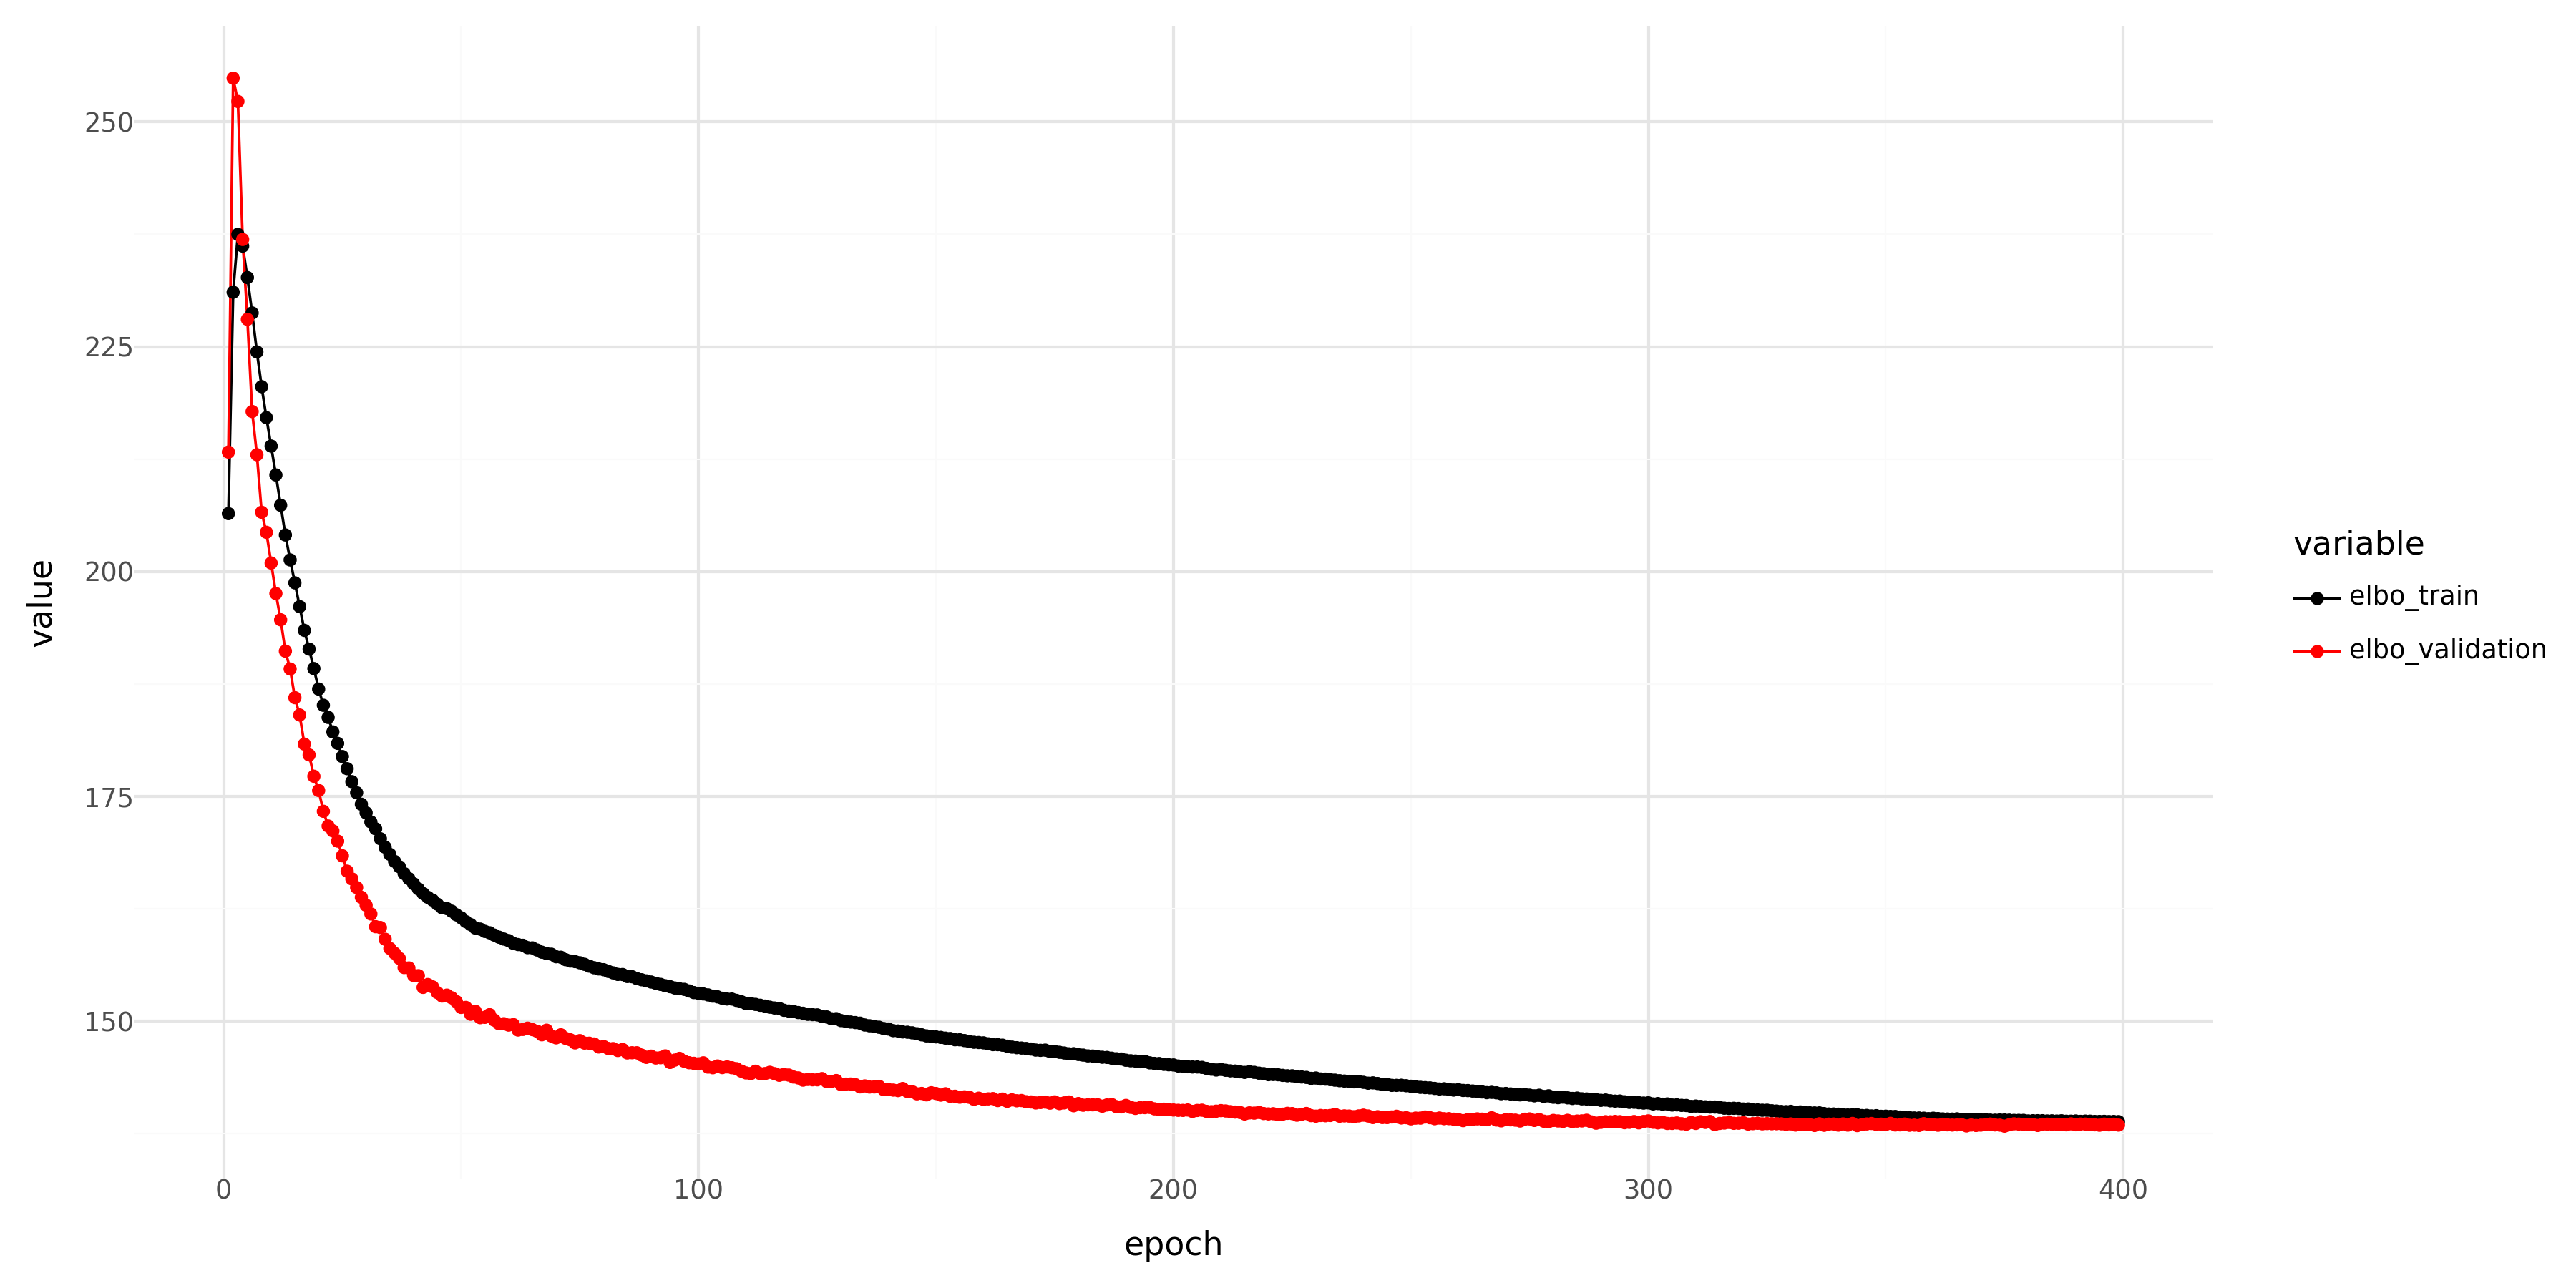

In [93]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

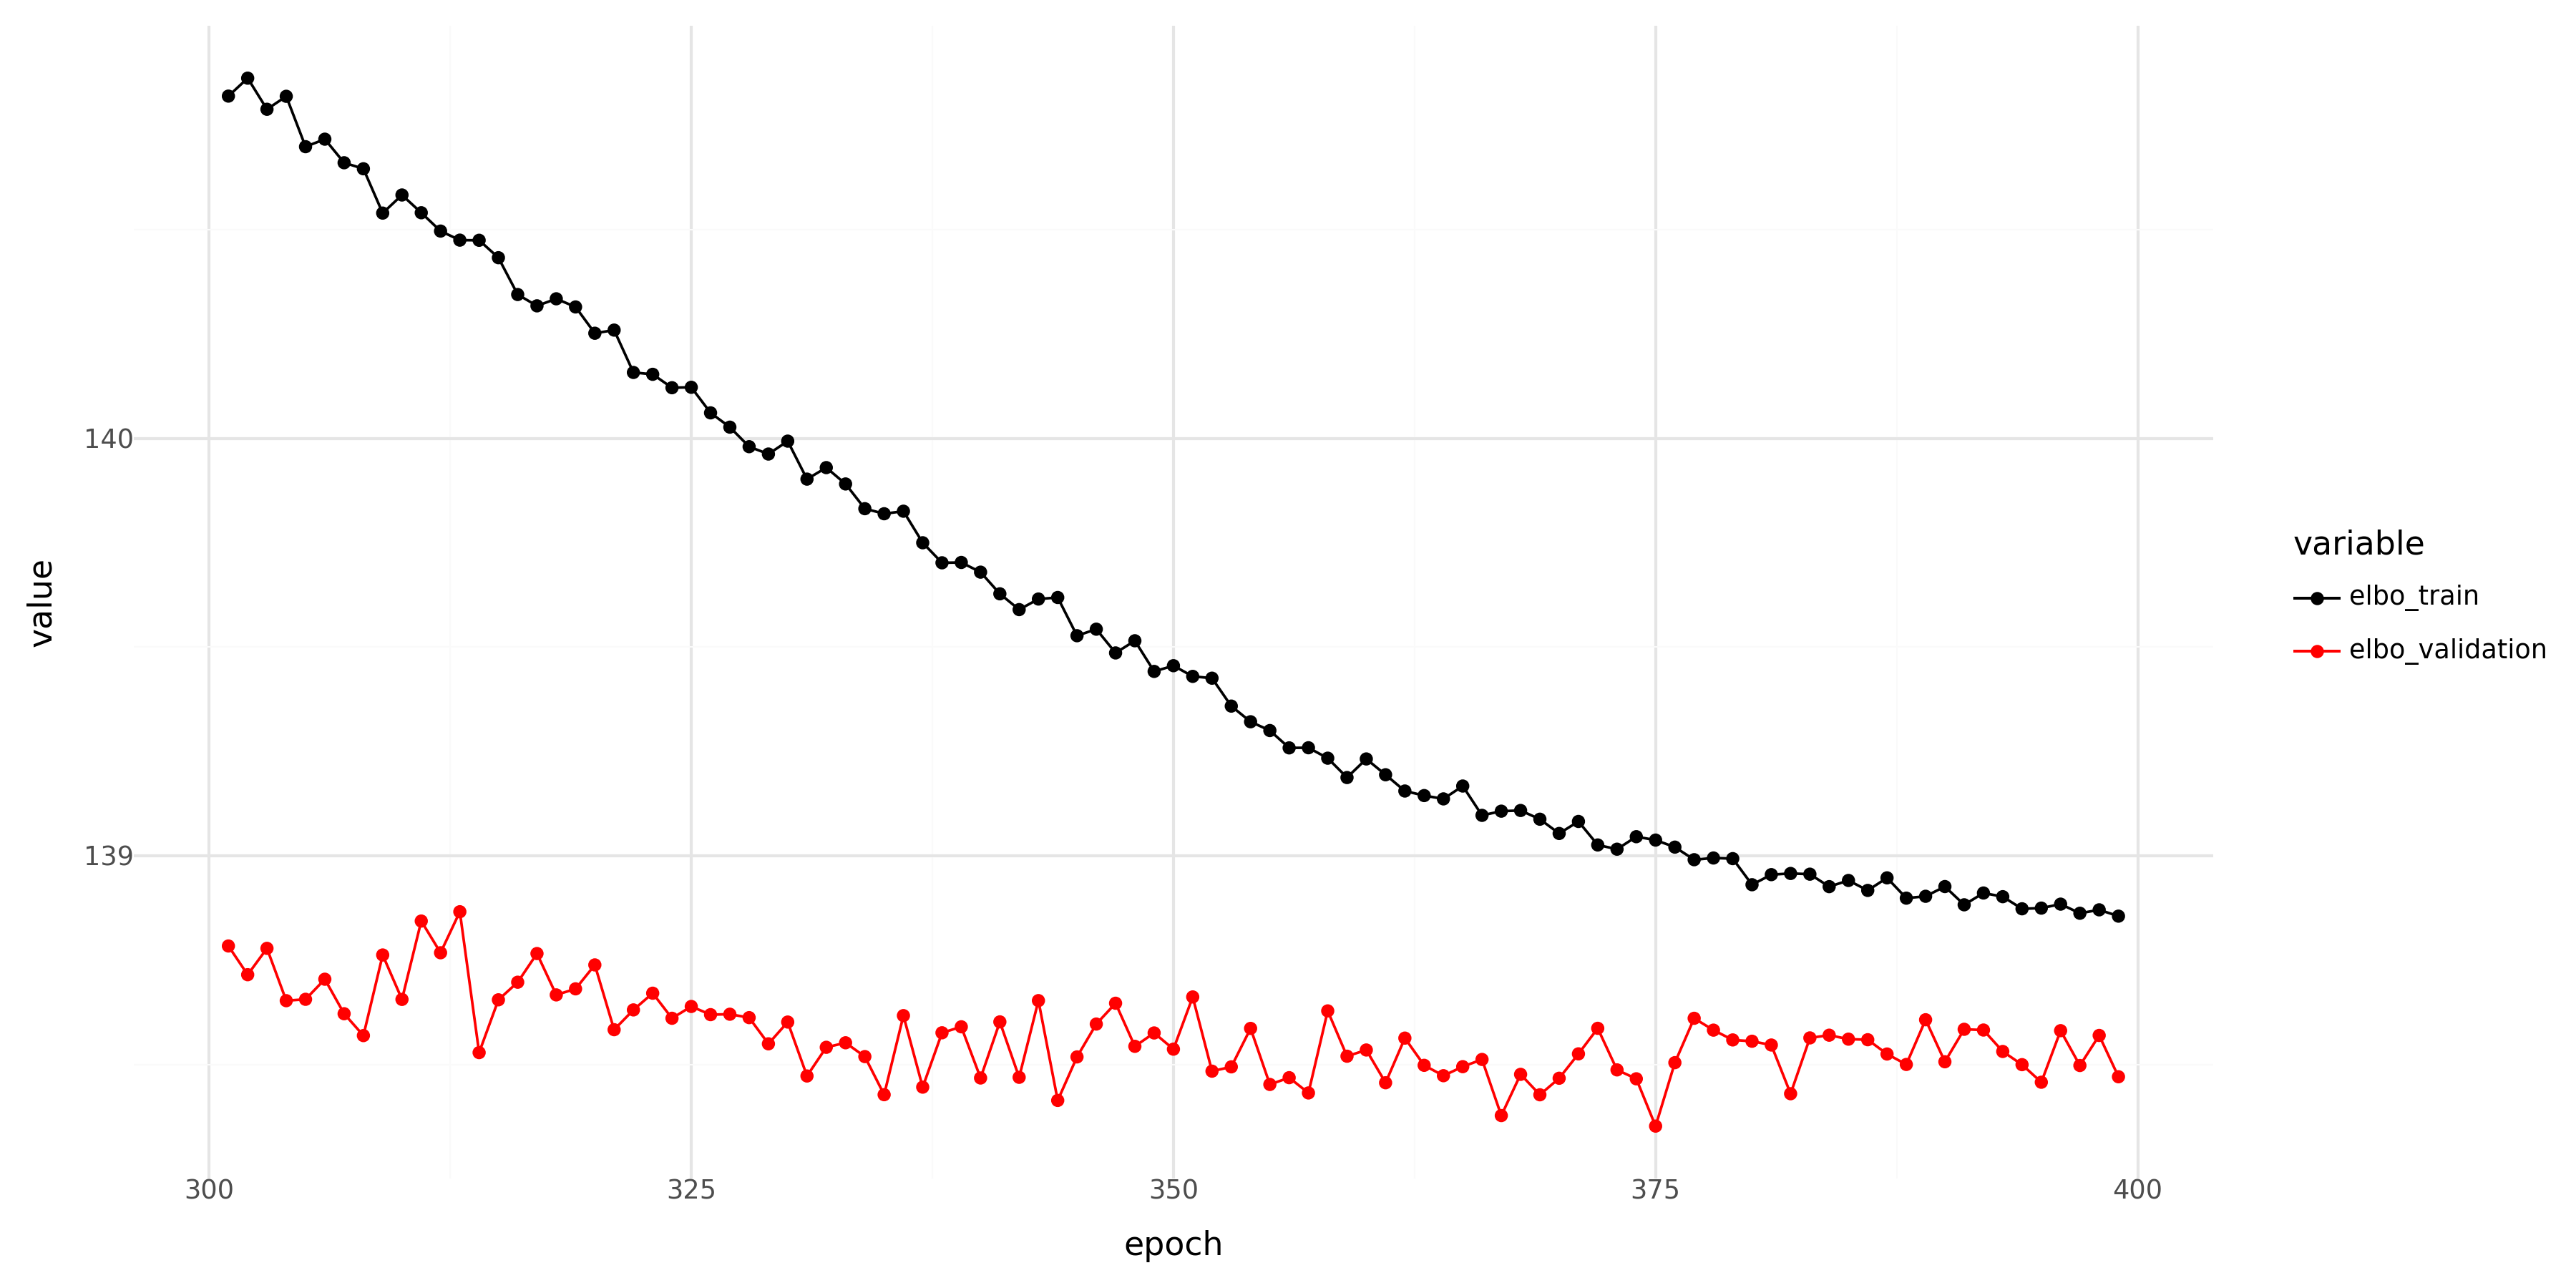

In [96]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 300'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Extract latent representation

In [88]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

+ Visualize dataset

In [97]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [ ]:
sc.set_figure_params(dpi = 300, figsize=(10,10))
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'C_scANVI', 'Library_Preparation_Protocol', 'Donor_ID'], ncols = 3, frameon = False, size = 6)

In [100]:
adata.write('data/10X_Xenium_adult_colon_data/Annotation_prediction/XeniumSC_and_fetalSC.h5ad')

In [101]:
adata_filtered = adata[adata.obs['dataset'] == 'query']

In [102]:
adata_filtered.obs['C_scANVI'].value_counts()

C_scANVI
MTRNR2L12+ASS1+_SC    10736
RPS10+_RPS17+_SC       3420
FXYD3+_CKB+_SC          724
Name: count, dtype: int64

In [103]:
adata_filtered.write_h5ad('data/10X_Xenium_adult_colon_data/Annotation_prediction/Xenium_SC_states_181024.h5ad')

+ Check scIB metrics

In [105]:
import scib
import scib.metrics
from scib_metrics.benchmark import Benchmarker

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/utils/_utils.py:40: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/utils/_kmeans.py:21: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annot

In [106]:
bm = Benchmarker(
    adata,
    batch_key='Donor_ID',
    label_key='C_scANVI',
    embedding_obsm_keys=['X_scANVI', 'X_scVI', 'X_pca', 'X_umap'],
    n_jobs=-1
)

bm.benchmark()

computing PCA
    with n_comps=50
    finished (0:00:00)


Embeddings:   0%|                                                  | 0/4 [00:00<?, ?it/s]/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
Embeddings:  25%|██████████▌                               | 1/4 [00:55<02:47, 55.69s/it]/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts

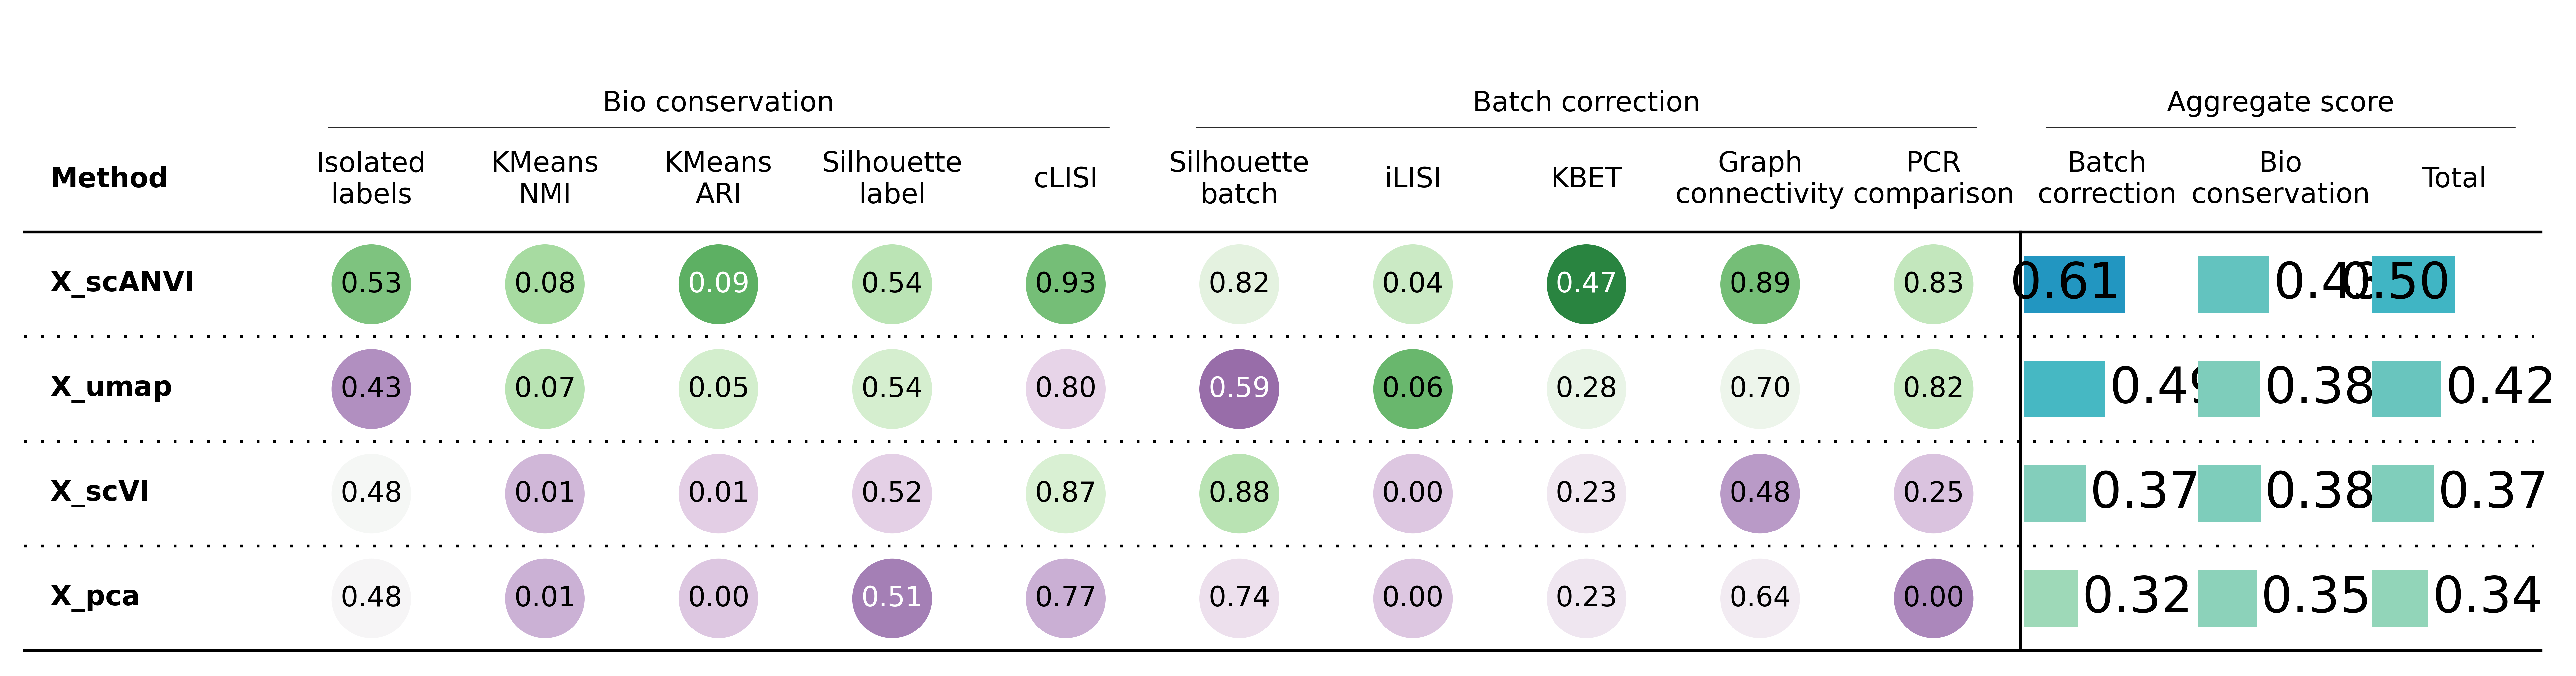

In [114]:
bm.plot_results_table(min_max_scale=False)